Methodology
The proposed project will be implemented using the following steps:

Data Collection: Data is collected and provided to you.
Data Pre-processing: Convert the musical scores into a format suitable for deep learning models. This involves converting the musical scores into MIDI files and applying data augmentation techniques.
Feature Extraction: Extract features from the MIDI files, such as notes, chords, and tempo, using music analysis tools.
Model Building: Develop a deep learning model using LSTM and CNN architectures to classify the musical scores according to the composer.
Model Training: Train the deep learning model using the pre-processed and feature-extracted data.
Model Evaluation: Evaluate the performance of the deep learning model using accuracy, precision, and recall metrics.
Model Optimization: Optimize the deep learning model by fine-tuning hyperparameters.

In [ ]:
import tensorflow as tf
# Sanity check to ensure GPU utilized if available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


TensorFlow version: 2.7.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Device Name: /device:GPU:0


In [5]:

import os
from zipfile import ZipFile
import numpy as np
import pretty_midi
import random

# Data Collection 
zip_path = "archive.zip"     # Path to kaggle file 
extract_to = "midi_subset"   # Folder to where .mid files will be extracted
COMPOSERS = ["Bach", "Beethoven", "Chopin", "Mozart"]

# Pre-processing 
MAX_LEN = 1000  # number of time frames per piano-roll
FS = 100        # sampling rate for piano-roll


os.makedirs(extract_to, exist_ok=True)
with ZipFile(zip_path, 'r') as zf:
    all_files = zf.namelist()
    print("ZIP sample entries:", all_files[:10])
    # Normalize composer names for matching
    composers_lower = [c.lower() for c in COMPOSERS]
    selected = []
    for file in all_files:
        # skip non-MID files
        if not file.lower().endswith('.mid'):
            continue
        # check any path segment matches a target composer
        segments = file.replace('\\', '/').split('/')
        if any(seg.lower() in composers_lower for seg in segments):
            selected.append(file)
    # extract selected files, preserving directory structure
    for f in selected:
        zf.extract(f, extract_to)
print(f"Extracted {len(selected)} .mid files into '{extract_to}'")


ZIP sample entries: ['Rothchild Symphony Rmw12 2mov.mid', 'Rothchlid Symphony Rmw12 3mov.mid', 'Sibelius Kuolema Vals op44.mid', 'Tchaicovsky Waltz of the Flowers.MID', 'Tchaikovsky Lake Of The Swans Act 1 1mov.mid', 'Tchaikovsky Lake Of The Swans Act 1 2mov.mid', 'Tchaikovsky Lake Of The Swans Act 1 3mov.mid', 'Tchaikovsky Lake Of The Swans Act 1 4mov.mid', 'Tchaikovsky Lake Of The Swans Act 1 5mov.mid', 'Tchaikovsky Lake Of The Swans Act 1 6mov.mid']
Extracted 1630 .mid files into 'midi_subset'


In [6]:
import os
import pretty_midi
from collections import defaultdict

# Simplified statistics: file count and average duration per composer

def safe_load_midi(path):
    """Attempt to load a MIDI file, return PrettyMIDI or None."""
    try:
        return pretty_midi.PrettyMIDI(path)
    except Exception:
        return None

# Directory containing extracted .mid files
base_dir = "midi_subset"

# Target composers
composers = ["Bach", "Beethoven", "Chopin", "Mozart"]

# Collect durations
durations = defaultdict(list)

for root, _, files in os.walk(base_dir):
    for fname in files:
        if not fname.lower().endswith('.mid'):
            continue
        path = os.path.join(root, fname)
        pm = safe_load_midi(path)
        if pm is None:
            continue
        # Determine composer by path segment
        segments = root.replace("\\", "/").split("/")
        composer = next((c for c in composers if c.lower() in (s.lower() for s in segments)), "Unknown")
        durations[composer].append(pm.get_end_time())

# Print summary
print("Composer Statistics:")
for composer in composers:
    durs = durations.get(composer, [])
    if not durs:
        print(f"  {composer}: 0 files")
    else:
        avg = sum(durs) / len(durs)
        mn = min(durs)
        mx = max(durs)
        print(f"  {composer}: {len(durs)} files, duration (s) avg={avg:.1f}, min={mn:.1f}, max={mx:.1f}")

c:\Users\dimit\miniconda3\envs\tf-gpu\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Composer Statistics:
  Bach: 1024 files, duration (s) avg=156.2, min=17.5, max=5209.3
  Beethoven: 212 files, duration (s) avg=508.4, min=21.9, max=5032.3
  Chopin: 136 files, duration (s) avg=220.8, min=23.3, max=1352.7
  Mozart: 256 files, duration (s) avg=400.8, min=26.1, max=1478.1


In [7]:

# Data Pre-processing 

def midi_to_pianoroll(path, fs=FS, max_length=MAX_LEN):
    """
    Load a .mid file and convert to a normalized piano-roll of shape (128, max_length).
    Pads with zeros or truncates to fit exactly max_length frames.
    Returns None if the file cannot be parsed.
    """
    try:
        pm = pretty_midi.PrettyMIDI(path)
    except Exception as e:
        print(f"Warning: could not parse '{path}': {e}")
        return None
    roll = pm.get_piano_roll(fs)
    # pad or truncate
    if roll.shape[1] < max_length:
        pad_width = max_length - roll.shape[1]
        roll = np.pad(roll, ((0,0),(0,pad_width)), mode='constant')
    else:
        roll = roll[:, :max_length]
    # normalize velocities to [0,1]
    max_val = np.max(roll) if np.max(roll) > 0 else 1
    return (roll / max_val).astype(np.float32)

# Directory to save piano-roll .npy files
pianoroll_dir = "pianorolls"
os.makedirs(pianoroll_dir, exist_ok=True)

# Walk through extracted .mid files and convert
count = 0
for root, dirs, files in os.walk(extract_to):
    for fname in files:
        if not fname.lower().endswith('.mid'):
            continue
        mid_path = os.path.join(root, fname)
        pr = midi_to_pianoroll(mid_path)
        if pr is None:
            continue
        # build save path preserving relative hierarchy
        rel = os.path.relpath(mid_path, extract_to)
        save_path = os.path.join(pianoroll_dir, os.path.splitext(rel)[0] + '.npy')
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        np.save(save_path, pr)
        count += 1
print(f"Converted and saved {count} piano-roll arrays under '{pianoroll_dir}'")




Converted and saved 1628 piano-roll arrays under 'pianorolls'


In [8]:
# Feature Extraction - Pitch Class Distribution

def midi_to_pitch_class_dist(path):
    """
    Load a .mid file and extract pitch class distribution.
    Returns a 12-element array representing frequency of each pitch class (C, C#, D, ..., B).
    Returns None if the file cannot be parsed.
    """
    try:
        pm = pretty_midi.PrettyMIDI(path)
    except Exception as e:
        print(f"Warning: could not parse '{path}': {e}")
        return None
    
    # Collect all notes from all instruments
    pitch_classes = []
    for instrument in pm.instruments:
        for note in instrument.notes:
            pitch_classes.append(note.pitch % 12)  # Convert to pitch class (0-11)
    
    if not pitch_classes:
        return np.zeros(12, dtype=np.float32)  # Return zeros if no notes
    
    # Count occurrences of each pitch class
    counts = np.bincount(pitch_classes, minlength=12)
    
    # Normalize to get distribution (frequencies sum to 1)
    distribution = counts / np.sum(counts)
    
    return distribution.astype(np.float32)

# Directory to save pitch class distribution .npy files
pitch_dir = "pitch"
os.makedirs(pitch_dir, exist_ok=True)

# Walk through extracted .mid files and extract pitch class distributions
count = 0
for root, dirs, files in os.walk(extract_to):
    for fname in files:
        if not fname.lower().endswith('.mid'):
            continue
        mid_path = os.path.join(root, fname)
        pcd = midi_to_pitch_class_dist(mid_path)
        if pcd is None:
            continue
        # build save path preserving relative hierarchy
        rel = os.path.relpath(mid_path, extract_to)
        save_path = os.path.join(pitch_dir, os.path.splitext(rel)[0] + '.npy')
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        np.save(save_path, pcd)
        count += 1

print(f"Extracted and saved {count} pitch class distributions under '{pitch_dir}'")


Extracted and saved 1628 pitch class distributions under 'pitch'


In [9]:
# Model Building - Multi-Branch CNN with Late Fusion

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, 
    Dense, GlobalAveragePooling2D, Concatenate, Activation
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from sklearn.utils.class_weight import compute_class_weight

def build_multibranch_cnn():
    """
    Build a multi-branch CNN that combines piano-roll and pitch class features using late fusion.
    
    Architecture:
    - Piano-roll branch: 2D CNN processing (128, 1000, 1) input
    - Pitch class branch: Dense layers processing (12,) input
    - Late fusion: Concatenate features from both branches
    - Final classifier: 4-class output (Bach, Beethoven, Chopin, Mozart)
    """
    
    # ========== PIANO-ROLL BRANCH (2D CNN) ==========
    piano_roll_input = Input(shape=(128, 1000, 1), name='piano_roll_input')
    
    # First convolutional block - capture note patterns
    x1 = Conv2D(32, (3, 3), padding='same', name='conv1_1')(piano_roll_input)
    x1 = BatchNormalization(name='bn1_1')(x1)
    x1 = Activation('relu', name='relu1_1')(x1)
    x1 = Conv2D(32, (3, 3), padding='same', name='conv1_2')(x1)
    x1 = BatchNormalization(name='bn1_2')(x1)
    x1 = Activation('relu', name='relu1_2')(x1)
    x1 = MaxPooling2D((2, 4), name='pool1')(x1)  # Reduce time dimension more aggressively
    x1 = Dropout(0.25, name='dropout1')(x1)
    
    # Second convolutional block - capture phrase patterns
    x1 = Conv2D(64, (3, 3), padding='same', name='conv2_1')(x1)
    x1 = BatchNormalization(name='bn2_1')(x1)
    x1 = Activation('relu', name='relu2_1')(x1)
    x1 = Conv2D(64, (3, 3), padding='same', name='conv2_2')(x1)
    x1 = BatchNormalization(name='bn2_2')(x1)
    x1 = Activation('relu', name='relu2_2')(x1)
    x1 = MaxPooling2D((2, 4), name='pool2')(x1)
    x1 = Dropout(0.25, name='dropout2')(x1)
    
    # Third convolutional block - capture higher-level patterns
    x1 = Conv2D(128, (3, 3), padding='same', name='conv3_1')(x1)
    x1 = BatchNormalization(name='bn3_1')(x1)
    x1 = Activation('relu', name='relu3_1')(x1)
    x1 = Conv2D(128, (3, 3), padding='same', name='conv3_2')(x1)
    x1 = BatchNormalization(name='bn3_2')(x1)
    x1 = Activation('relu', name='relu3_2')(x1)
    x1 = MaxPooling2D((2, 4), name='pool3')(x1)
    x1 = Dropout(0.25, name='dropout3')(x1)
    
    # Global average pooling to get fixed-size feature vector
    x1 = GlobalAveragePooling2D(name='global_avg_pool')(x1)
    
    # Dense layer for piano-roll features
    piano_features = Dense(256, activation='relu', name='piano_dense1')(x1)
    piano_features = BatchNormalization(name='piano_bn')(piano_features)
    piano_features = Dropout(0.5, name='piano_dropout')(piano_features)
    piano_features = Dense(128, activation='relu', name='piano_dense2')(piano_features)
    
    # ========== PITCH CLASS BRANCH (Dense layers) ==========
    pitch_input = Input(shape=(12,), name='pitch_input')
    
    # Dense layers for pitch class distribution
    x2 = Dense(64, activation='relu', name='pitch_dense1')(pitch_input)
    x2 = BatchNormalization(name='pitch_bn1')(x2)
    x2 = Dropout(0.3, name='pitch_dropout1')(x2)
    
    x2 = Dense(32, activation='relu', name='pitch_dense2')(x2)
    x2 = BatchNormalization(name='pitch_bn2')(x2)
    x2 = Dropout(0.3, name='pitch_dropout2')(x2)
    
    pitch_features = Dense(16, activation='relu', name='pitch_dense3')(x2)
    
    # ========== LATE FUSION ==========
    # Concatenate features from both branches
    combined_features = Concatenate(name='feature_fusion')([piano_features, pitch_features])
    
    # Final classification layers
    x = Dense(64, activation='relu', name='fusion_dense1')(combined_features)
    x = BatchNormalization(name='fusion_bn')(x)
    x = Dropout(0.5, name='fusion_dropout')(x)
    
    # Output layer - 4 composers
    predictions = Dense(4, activation='softmax', name='predictions')(x)
    
    # Create the model
    model = Model(
        inputs=[piano_roll_input, pitch_input], 
        outputs=predictions,
        name='MultiBranch_Composer_CNN'
    )
    
    return model

# Build the model
model = build_multibranch_cnn()

# Display model architecture
model.summary()

# Compile the model with class weights to handle imbalance
# Class weights based on dataset: Bach=1024, Beethoven=212, Chopin=136, Mozart=256
class_counts = [1024, 212, 136, 256]  # Bach, Beethoven, Chopin, Mozart
total_samples = sum(class_counts)
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}

print(f"Class weights to handle imbalance: {class_weights}")

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()],
)

print("✅ Multi-branch CNN model built and compiled successfully!")
print(f"📊 Model has {model.count_params():,} trainable parameters")
print(f"🎵 Ready to process piano-roll ({model.input[0].shape}) and pitch class ({model.input[1].shape}) inputs")


Model: "MultiBranch_Composer_CNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 piano_roll_input (InputLayer)  [(None, 128, 1000,   0           []                               
                                1)]                                                               
                                                                                                  
 conv1_1 (Conv2D)               (None, 128, 1000, 3  320         ['piano_roll_input[0][0]']       
                                2)                                                                
                                                                                                  
 bn1_1 (BatchNormalization)     (None, 128, 1000, 3  128         ['conv1_1[0][0]']                
                                2)                                         

In [10]:
# SIMPLIFIED Model Training (No Matplotlib Dependencies)
# This version avoids the NumPy compatibility issue with matplotlib

import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# Removed matplotlib import to avoid NumPy compatibility issue
# from tqdm import tqdm  # Also commenting this in case it has issues

def load_training_data_simple(pianoroll_dir="pianorolls", pitch_dir="pitch", composers=["Bach", "Beethoven", "Chopin", "Mozart"]):
    """
    Load piano-roll and pitch class data for training.
    Returns piano-roll arrays, pitch class arrays, and labels.
    """
    piano_rolls = []
    pitch_classes = []
    labels = []
    filenames = []
    
    print("Loading training data...")
    file_count = 0
    
    # Walk through pianoroll directory to find all .npy files
    for root, dirs, files in os.walk(pianoroll_dir):
        for fname in files:
            if not fname.endswith('.npy'):
                continue
                
            file_count += 1
            if file_count % 100 == 0:
                print(f"  Processed {file_count} files...")
                
            # Get relative path for label assignment
            rel_path = os.path.relpath(root, pianoroll_dir)
            
            # Determine composer from path
            composer = None
            for i, comp in enumerate(composers):
                if comp.lower() in rel_path.lower():
                    composer = i
                    break
            
            if composer is None:
                continue  # Skip files not matching target composers
            
            # Load piano-roll data
            piano_path = os.path.join(root, fname)
            try:
                piano_data = np.load(piano_path)
                
                # Load corresponding pitch class data
                pitch_path = os.path.join(pitch_dir, os.path.relpath(piano_path, pianoroll_dir))
                pitch_data = np.load(pitch_path)
                
                # Add to lists
                piano_rolls.append(piano_data)
                pitch_classes.append(pitch_data)
                labels.append(composer)
                filenames.append(fname)
                
            except Exception as e:
                print(f"Error loading {piano_path}: {e}")
                continue
    
    # Convert to numpy arrays
    print("Converting to numpy arrays...")
    piano_rolls = np.array(piano_rolls)
    pitch_classes = np.array(pitch_classes)
    labels = np.array(labels)
    
    # Reshape piano-roll data to add channel dimension if needed
    if len(piano_rolls.shape) == 3:
        piano_rolls = piano_rolls[..., np.newaxis]
    
    print(f"Loaded {len(piano_rolls)} samples:")
    for i, composer in enumerate(composers):
        count = np.sum(labels == i)
        print(f"  {composer}: {count} samples")
    
    print(f"Piano-roll shape: {piano_rolls.shape}")
    print(f"Pitch class shape: {pitch_classes.shape}")
    print(f"Labels shape: {labels.shape}")
    
    return piano_rolls, pitch_classes, labels, filenames

# Load the data
print("🔄 Starting data loading...")
X_piano, X_pitch, y, filenames = load_training_data_simple()

# Split the data (80% train, 20% validation)
print("🔄 Splitting data...")
X_piano_train, X_piano_val, X_pitch_train, X_pitch_val, y_train, y_val = train_test_split(
    X_piano, X_pitch, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Ensure balanced split across composers
)

print(f"\nTraining set: {len(X_piano_train)} samples")
print(f"Validation set: {len(X_piano_val)} samples")
print(f"Train class distribution: {np.bincount(y_train)}")
print(f"Val class distribution: {np.bincount(y_val)}")

# Define training callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_composer_model.keras',
        monitor='val_sparse_categorical_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    )
]

print("\n🚀 Starting model training...")
print("=" * 50)

# Train the model
history = model.fit(
    [X_piano_train, X_pitch_train], y_train,
    validation_data=([X_piano_val, X_pitch_val], y_val),
    epochs=100,  # Will likely stop early due to callback
    batch_size=32,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training completed!")
print("=" * 50)

# Save training history for later visualization
np.save('training_history.npy', history.history)
print("💾 Training history saved as 'training_history.npy'")


🔄 Starting data loading...
Loading training data...
  Processed 100 files...
  Processed 200 files...
  Processed 300 files...
  Processed 400 files...
  Processed 500 files...
  Processed 600 files...
  Processed 700 files...
  Processed 800 files...
  Processed 900 files...
  Processed 1000 files...
  Processed 1100 files...
  Processed 1200 files...
  Processed 1300 files...
  Processed 1400 files...
  Processed 1500 files...
  Processed 1600 files...
Converting to numpy arrays...
Loaded 1628 samples:
  Bach: 1024 samples
  Beethoven: 212 samples
  Chopin: 136 samples
  Mozart: 256 samples
Piano-roll shape: (1628, 128, 1000, 1)
Pitch class shape: (1628, 12)
Labels shape: (1628,)
🔄 Splitting data...

Training set: 1302 samples
Validation set: 326 samples
Train class distribution: [819 169 109 205]
Val class distribution: [205  43  27  51]

🚀 Starting model training...
Epoch 1/100
41/41 [==============================] - ETA: 0s - loss: 1.9968 - sparse_categorical_accuracy: 0.2765
Epo

📈 Visualizing training history...


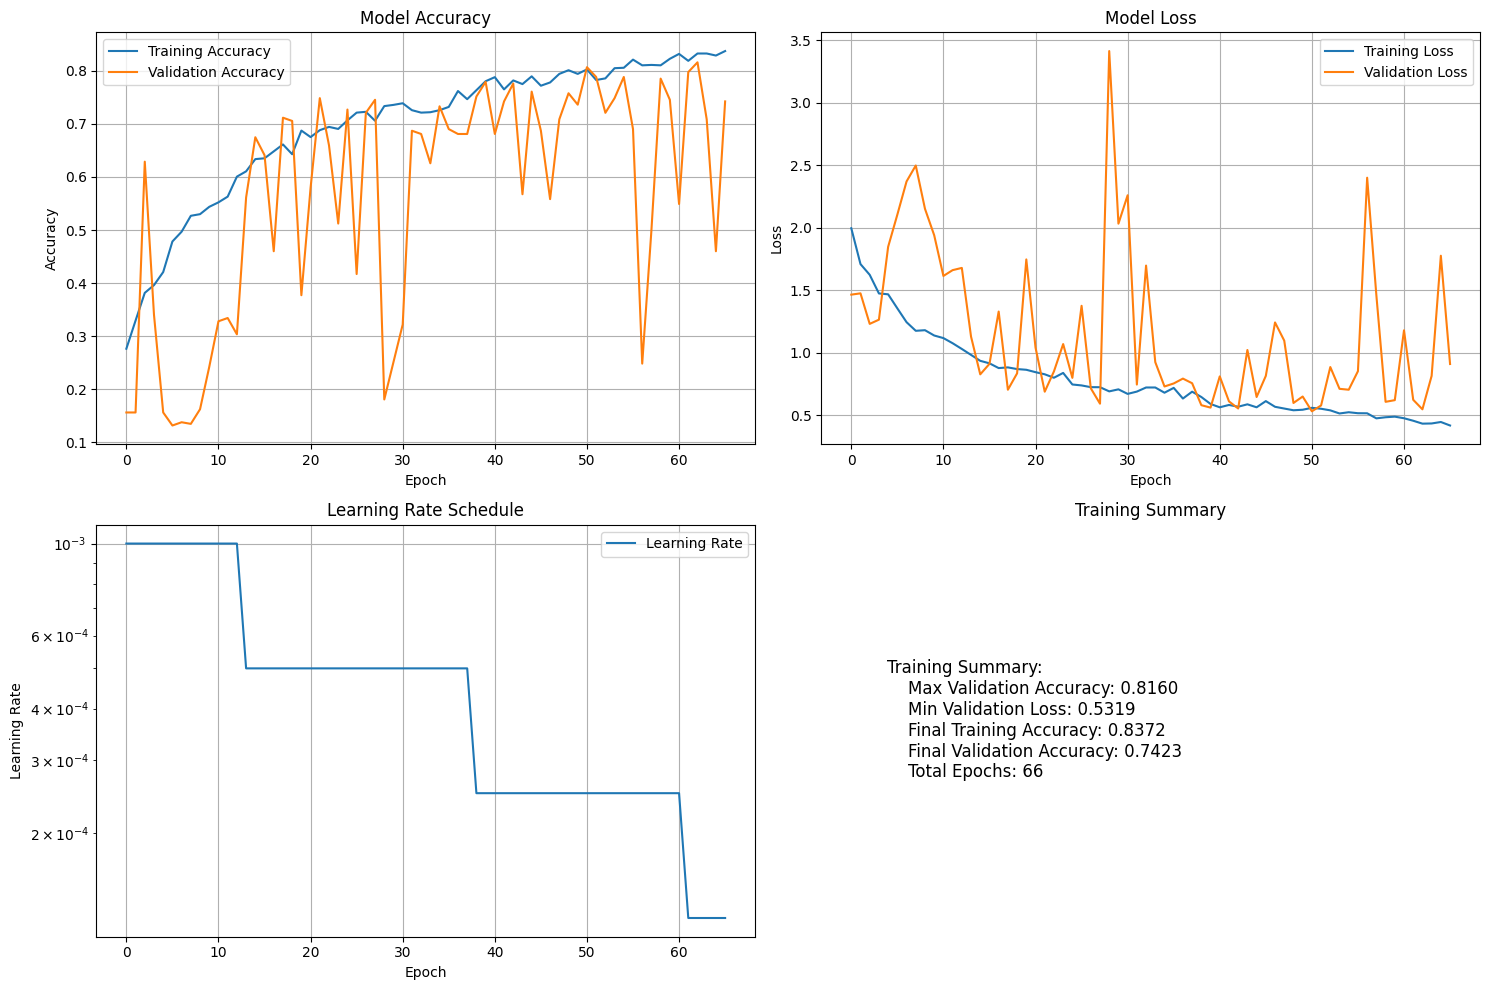

Making predictions on validation set...

📊 Model Performance:
Overall Accuracy: 0.8067

Per-Class Metrics:
  Bach:
    Precision: 0.8962
    Recall: 0.9268
    F1-Score: 0.9113
    Support: 205
  Beethoven:
    Precision: 0.6818
    Recall: 0.3488
    F1-Score: 0.4615
    Support: 43
  Chopin:
    Precision: 0.7586
    Recall: 0.8148
    F1-Score: 0.7857
    Support: 27
  Mozart:
    Precision: 0.5714
    Recall: 0.7059
    F1-Score: 0.6316
    Support: 51


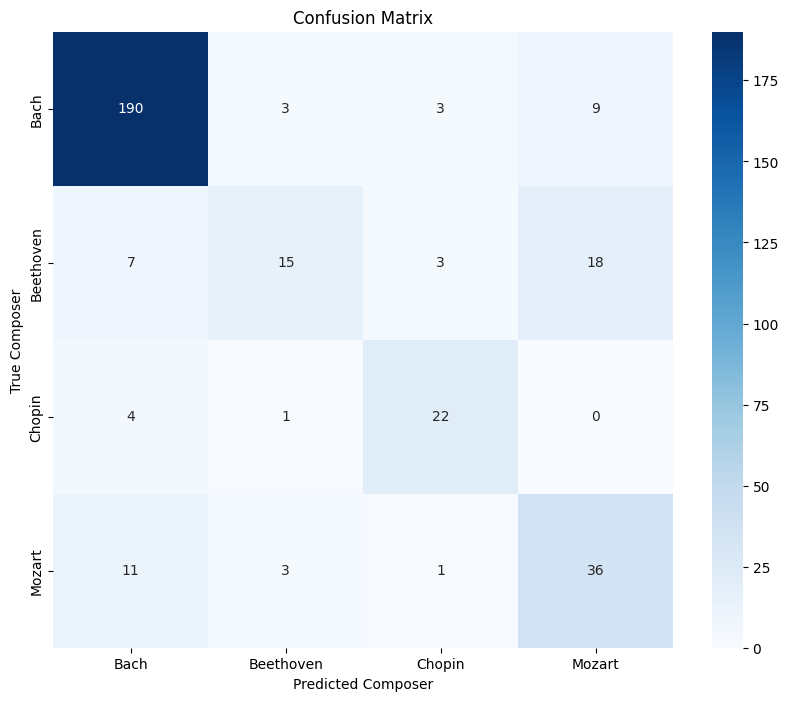


📋 Detailed Classification Report:
              precision    recall  f1-score   support

        Bach       0.90      0.93      0.91       205
   Beethoven       0.68      0.35      0.46        43
      Chopin       0.76      0.81      0.79        27
      Mozart       0.57      0.71      0.63        51

    accuracy                           0.81       326
   macro avg       0.73      0.70      0.70       326
weighted avg       0.81      0.81      0.80       326


💾 Model saved as 'final_composer_classifier.keras'

🎼 Sample Predictions:
❌ True: Bach       | Predicted: Mozart     | Confidence: 0.527
✅ True: Mozart     | Predicted: Mozart     | Confidence: 0.855
✅ True: Bach       | Predicted: Bach       | Confidence: 0.992
✅ True: Bach       | Predicted: Bach       | Confidence: 0.535
✅ True: Bach       | Predicted: Bach       | Confidence: 0.988
✅ True: Bach       | Predicted: Bach       | Confidence: 0.959
✅ True: Bach       | Predicted: Bach       | Confidence: 0.991
✅ True: Bach  

In [11]:
# Model Evaluation and Visualization

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def plot_training_history(history):
    """Plot training and validation metrics."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot training & validation accuracy
    axes[0, 0].plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot training & validation loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Plot learning rate (if available)
    if 'lr' in history.history:
        axes[1, 0].plot(history.history['lr'], label='Learning Rate')
        axes[1, 0].set_title('Learning Rate Schedule')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_yscale('log')
        axes[1, 0].legend()
        axes[1, 0].grid(True)
    
    # Summary statistics
    max_val_acc = max(history.history['val_sparse_categorical_accuracy'])
    min_val_loss = min(history.history['val_loss'])
    final_train_acc = history.history['sparse_categorical_accuracy'][-1]
    final_val_acc = history.history['val_sparse_categorical_accuracy'][-1]
    
    summary_text = f"""Training Summary:
    Max Validation Accuracy: {max_val_acc:.4f}
    Min Validation Loss: {min_val_loss:.4f}
    Final Training Accuracy: {final_train_acc:.4f}
    Final Validation Accuracy: {final_val_acc:.4f}
    Total Epochs: {len(history.history['loss'])}
    """
    
    axes[1, 1].text(0.1, 0.5, summary_text, fontsize=12, 
                    verticalalignment='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Training Summary')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_piano_val, X_pitch_val, y_val, composers):
    """Evaluate model performance and show detailed metrics."""
    
    # Make predictions
    print("Making predictions on validation set...")
    y_pred_proba = model.predict([X_piano_val, X_pitch_val], verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(y_val, y_pred, average=None)
    
    print(f"\n📊 Model Performance:")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print("\nPer-Class Metrics:")
    for i, composer in enumerate(composers):
        print(f"  {composer}:")
        print(f"    Precision: {precision[i]:.4f}")
        print(f"    Recall: {recall[i]:.4f}")
        print(f"    F1-Score: {f1[i]:.4f}")
        print(f"    Support: {support[i]}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=composers, yticklabels=composers)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Composer')
    plt.ylabel('True Composer')
    plt.show()
    
    # Classification Report
    print("\n📋 Detailed Classification Report:")
    print(classification_report(y_val, y_pred, target_names=composers))
    
    return y_pred, y_pred_proba

# Plot training history
print("📈 Visualizing training history...")
plot_training_history(history)

# Evaluate the model
composers = ["Bach", "Beethoven", "Chopin", "Mozart"]
y_pred, y_pred_proba = evaluate_model(model, X_piano_val, X_pitch_val, y_val, composers)

# Save the final model
model.save('final_composer_classifier.keras')
print("\n💾 Model saved as 'final_composer_classifier.keras'")

# Display some prediction examples
print("\n🎼 Sample Predictions:")
for i in range(min(10, len(y_val))):
    true_composer = composers[y_val[i]]
    pred_composer = composers[y_pred[i]]
    confidence = y_pred_proba[i][y_pred[i]]
    status = "✅" if y_val[i] == y_pred[i] else "❌"
    print(f"{status} True: {true_composer:10} | Predicted: {pred_composer:10} | Confidence: {confidence:.3f}")
